<a href="https://colab.research.google.com/github/seanrjohnson/esmologs/blob/main/notebooks/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sensitive remote homology search by local alignment of small positional embeddings from protein language models


## Data analysis code

This notebook downloads search results from Zenodo and creates the figure and summary tables from the manuscript

In [5]:
#@title Import dependencies

import pandas as pd
import os # accessing directory structure
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import OrderedDict
import numpy as np



def read_seq_search_triple(file, dataset_name, seq_to_family, seq_to_clan, seq_to_pid_bin):
    df = pd.read_table(file, sep="\t",index_col=None, header=None, names=['query_seq','target_seq','score'])
    # keep only max score for each query
    df = df.loc[df.groupby('query_seq')['score'].idxmax()].copy()


    df["dataset"] = dataset_name

    df['query_family'] = df['query_seq'].map(lambda x: seq_to_family[x])
    df['target_family'] = df['target_seq'].map(lambda x: seq_to_family[x])
    df['query_clan'] = df['query_seq'].map(lambda x: seq_to_clan[x])
    df['target_clan'] = df['target_seq'].map(lambda x: seq_to_clan[x])
    df['pid_bin'] = df['query_seq'].map(lambda x: seq_to_pid_bin[x])
    return df

def read_profile_search_triple(file, dataset_name, seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin):
    df = pd.read_table(file, sep="\t",index_col=None, header=None, names=['query_seq','target_family','score'])
    # keep only max score for each query
    df = df.loc[df.groupby('query_seq')['score'].idxmax()].copy()

    df["dataset"] = dataset_name

    df['query_family'] = df['query_seq'].map(lambda x: seq_to_family[x])
    df['query_clan'] = df['query_seq'].map(lambda x: seq_to_clan[x])

    df["target_clan"] = df["target_family"].map(lambda x: family_to_clan[x])
    df['pid_bin'] = df['query_seq'].map(lambda x: seq_to_pid_bin[x])
    return df


def get_pid_bin(acc, acc_bins=((0,12),(12,14),(14,16),(16,18),(18,20),(20,22),(22,24),(24,26),(26,100))):
    for i, (min_acc, max_acc) in enumerate(acc_bins):
        if acc >= min_acc and acc < max_acc:
            return f"{min_acc}-{max_acc}"
    raise ValueError("pid {} not in any bin".format(acc))

In [3]:
#@title Download and extract data

!wget https://zenodo.org/record/8174960/files/search_results.tar.gz
!wget https://zenodo.org/record/8174960/files/pfamN_family_clans.tsv
!wget https://zenodo.org/record/8174960/files/pfamN_pids.tsv
!wget https://zenodo.org/records/10204059/files/SCOPe40_processed.tar.gz
!tar -xf search_results.tar.gz
!tar -xf SCOPe40_processed.tar.gz

--2023-11-07 09:05:03--  https://zenodo.org/record/8174960/files/search_results.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.22.33, 188.185.33.206, 188.185.10.78, ...
Connecting to zenodo.org (zenodo.org)|188.185.22.33|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/8174960/files/search_results.tar.gz [following]
--2023-11-07 09:05:04--  https://zenodo.org/records/8174960/files/search_results.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 407317221 (388M) [application/octet-stream]
Saving to: ‘search_results.tar.gz’

search_results.tar. 100%[===================>] 388.45M  16.7MB/s    in 18s     

2023-11-07 09:05:22 (21.1 MB/s) - ‘search_results.tar.gz’ saved [407317221/407317221]

--2023-11-07 09:05:23--  https://zenodo.org/record/8174960/files/pfamN_family_clans.tsv
Resolving zenodo.org (zenodo.org)... 188.185.22.33, 188.185.33.206, 188.185.10.78, ...
Connecting to

In [46]:
#@title Load datasets
clans_data=pd.read_table("pfamN_family_clans.tsv", index_col=0)
seq_to_clan = clans_data["clan"].to_dict()

pid_data = pd.read_csv('pfamN_pids.tsv', sep="\t", index_col=0)
pid_data["clan"] = pid_data.index.map(lambda x: seq_to_clan[x])
pid_data["pid_bin"] = pid_data["max_pid"].map(get_pid_bin)
family_pid_bin_sizes = pid_data.groupby("pid_bin").count()["family"].to_dict()
clan_pid_bin_sizes = pid_data.dropna(subset=["clan"]).groupby("pid_bin").count()["family"].to_dict()

seq_to_family = clans_data["family_id"].to_dict()

seq_to_pid_bin = pid_data["pid_bin"].to_dict()
family_to_clan = clans_data.set_index("family_id")["clan"].to_dict()

datasets_all = [
           read_profile_search_triple("search_results/1_test_hits_hmmscan.tsv","1. hmmscan, aa seq, aa hmmer profile",seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin),
           read_seq_search_triple("search_results/2_test_hits_phmmer.tsv", "2. phmmer, aa seq, aa seq",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_seq_search_triple("search_results/3_test_esm2_3B_msas_pnone_hmmsearch.tsv", "3. hmmsearch, pred hmmer profile, aa seq",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_seq_search_triple("search_results/4_test_esm2_3B_msas_hmmsearch.tsv", "4. hmmsearch, pred hmmer profile dchlet, aa seq",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_profile_search_triple("search_results/5_test_hits_hhblits_esm2_3B_test_pep_aligned_train.tsv", "5. hhblits, pred hhsuite profile, aa hhsuite profile",seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin),
           read_seq_search_triple("search_results/6_test_hits_hhblits_esm2_3B_test_esm2_3B_train.tsv", "6. hhblits, pred hhsuite profile, pred hhsuite profile",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_seq_search_triple("search_results/7_test_train_3Di_pred_foldseek.tsv", "7. foldseek, pred 3Di, pred 3Di",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_seq_search_triple("search_results/8_test_train_3Di_pred_foldseek_3Di_only.tsv", "8. foldseek 3Di-only, pred 3Di, pred 3Di",seq_to_family, seq_to_clan,  seq_to_pid_bin),
           read_profile_search_triple("search_results/9_test_3Di_pred_3Di_aahmmscan.tsv", "9. hmmscan, pred 3Di, pred 3Di hmmer profile", seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin),
           read_profile_search_triple("search_results/10_test_3Di_pred_3Di_hmmscan.tsv", "10. 3Di_hmmscan, pred 3Di, pred 3Di hmmer3Di profile", seq_to_family, seq_to_clan, family_to_clan, seq_to_pid_bin),
           ]
hue_order = [df.iloc[0]["dataset"] for df in datasets_all]
marker_order = [df.iloc[0]["dataset"] for df in datasets_all]

datasets_combined = pd.concat(datasets_all, ignore_index=True)
datasets_combined["correct_family"] = datasets_combined["query_family"] == datasets_combined["target_family"]
datasets_combined["correct_clan"] = datasets_combined["query_clan"] == datasets_combined["target_clan"]


In [57]:
hue_order

['1. hmmscan, aa seq, aa hmmer profile',
 '2. phmmer, aa seq, aa seq',
 '3. hmmsearch, pred hmmer profile, aa seq',
 '4. hmmsearch, pred hmmer profile dchlet, aa seq',
 '5. hhblits, pred hhsuite profile, aa hhsuite profile',
 '6. hhblits, pred hhsuite profile, pred hhsuite profile',
 '7. foldseek, pred 3Di, pred 3Di',
 '8. foldseek 3Di-only, pred 3Di, pred 3Di',
 '9. hmmscan, pred 3Di, pred 3Di hmmer profile',
 '10. 3Di_hmmscan, pred 3Di, pred 3Di hmmer3Di profile']

/tmp/ipykernel_12497/2599953691.py:90: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


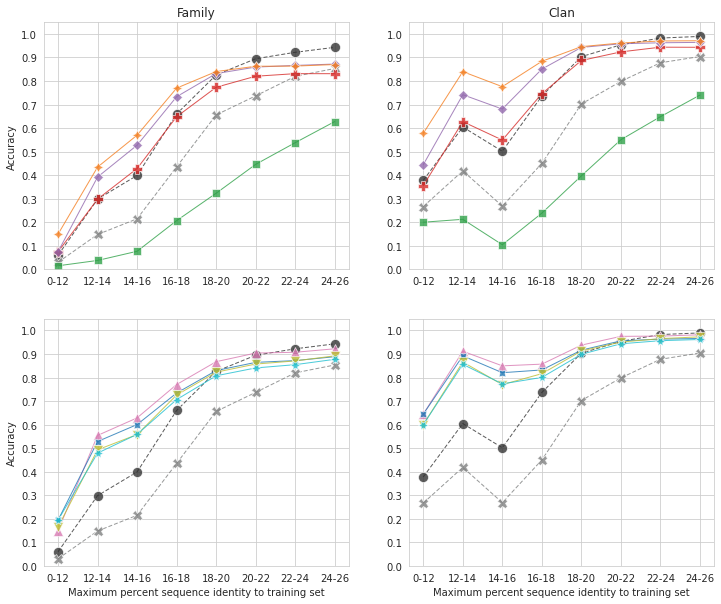

In [62]:
#@title Draw graph
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)
palette=['#333333', '#7F8080', '#2FA148', '#D62A28', '#9268AD', '#F57F20', '#D87AB2', '#2278B5', '#BCBE32', '#1FBFD0'] # '#8D574C'
dashes = {k:tuple() for k in hue_order}
dashes["1. hmmscan, aa seq, aa hmmer profile"] = (4,2)
dashes["2. phmmer, aa seq, aa seq"] = (4,2)
# set first two rows to be the same dashes

for fig_row, data_subset in enumerate((
    {"1. hmmscan, aa seq, aa hmmer profile","2. phmmer, aa seq, aa seq", "3. hmmsearch, pred hmmer profile, aa seq", "4. hmmsearch, pred hmmer profile dchlet, aa seq", "5. hhblits, pred hhsuite profile, aa hhsuite profile", "6. hhblits, pred hhsuite profile, pred hhsuite profile"}, 
    {"1. hmmscan, aa seq, aa hmmer profile","2. phmmer, aa seq, aa seq","7. foldseek, pred 3Di, pred 3Di","8. foldseek 3Di-only, pred 3Di, pred 3Di","9. hmmscan, pred 3Di, pred 3Di hmmer profile","10. 3Di_hmmscan, pred 3Di, pred 3Di hmmer3Di profile"},
    )):

    datasets_subset = datasets_combined[datasets_combined["dataset"].isin(data_subset)]

    family_accuracies = {"dataset":[], "pid_bin":[], "accuracy":[]}
    for (dataset, pid_bin), group in datasets_subset.groupby(["dataset","pid_bin"]):
        count = len(group)
        #correct = len(group[group["query_family"] == group["target_family"]])
        correct = sum(group["correct_family"])
        family_accuracies["dataset"].append(dataset)
        family_accuracies["pid_bin"].append(pid_bin)
        family_accuracies["accuracy"].append(correct/family_pid_bin_sizes[pid_bin])
    family_accuracies = pd.DataFrame(family_accuracies)

    clan_accuracies = {"dataset":[], "pid_bin":[], "accuracy":[]}

    for (dataset, pid_bin), group in datasets_subset.dropna(subset=["query_clan"]).groupby(["dataset","pid_bin"]):
        count = len(group)
        # correct = len(group[group["query_clan"] == group["target_clan"]])
        correct = sum(group["correct_clan"])
        clan_accuracies["dataset"].append(dataset)
        clan_accuracies["pid_bin"].append(pid_bin)
        clan_accuracies["accuracy"].append(correct/clan_pid_bin_sizes[pid_bin])
    clan_accuracies = pd.DataFrame(clan_accuracies)
    # print(clan_accuracies)
    # print(hue_order)
    ax = sns.lineplot(x="pid_bin", y="accuracy", hue='dataset', style='dataset', markers=True, dashes=dashes, markersize=10, linewidth=1., data=family_accuracies, hue_order=hue_order, style_order=hue_order, alpha=0.8, ax=axes[fig_row,0], legend=True, palette=palette)
    ax.set_ylim([0, 1.05])
    ax.set_ylabel("Accuracy")
    ax.set_xlabel(None)
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.get_legend().remove()
    if fig_row == 0:
        ax.set_title("Family")
    else:
        ax.set_xlabel("Maximum percent sequence identity to training set")

    ax = sns.lineplot(x="pid_bin", y="accuracy", hue='dataset', style="dataset", markers=True, dashes=dashes, markersize=10, linewidth=1., data=clan_accuracies, hue_order=hue_order, style_order=hue_order, alpha=0.8, ax=axes[fig_row,1], legend=True, palette=palette)
    ax.set_ylim([0, 1.05])
    ax.set_ylabel("")
    ax.set_xlabel(None)
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    if fig_row == 0:
        ax.set_title("Clan")
    else:
        ax.set_xlabel("Maximum percent sequence identity to training set")
    ax.get_legend().remove()

# Initialize an empty dictionary to collect unique handles (the markers in the legend)
unique_handles_dict = {}

# Loop through all axes to collect unique legend handles
for row_axes in axes:
    for ax in row_axes:
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            # If the label is in hue_order and not added yet, add to dict
            if label in hue_order and label not in unique_handles_dict:
                unique_handles_dict[label] = handle

# Now create a list of handles and labels in the order of `hue_order`
unique_handles = [unique_handles_dict[label] for label in hue_order if label in unique_handles_dict]
unique_labels = [label for label in hue_order if label in unique_handles_dict]

# Remove any existing legends from axes
for row_axes in axes:
    for ax in row_axes:
        ax.legend().remove()

# Create a new figure-level legend using the unique handles and labels
#fig.legend(unique_handles, unique_labels, bbox_to_anchor=(0.91, 0.85), loc=2, borderaxespad=0., fontsize=10, title="Algorithm, query (test split), target (train split)")


#fig.legend(bbox_to_anchor=(0.91, 0.85), loc=2, borderaxespad=0., fontsize=10, title="Algorithm, query (test split), target (train split)")
fig.savefig("accuracy_vs_pid_bin.svg", bbox_inches='tight', dpi=300)
fig.savefig("accuracy_vs_pid_bin.png", bbox_inches='tight', dpi=300)
fig.show()


In [22]:
#@title summary statistics
print(family_pid_bin_sizes)

print(clan_pid_bin_sizes)
num_clans = sum(clan_pid_bin_sizes.values())
num_families = sum(family_pid_bin_sizes.values())

print(f"num_families: {num_families}\n")
print(f"num_clans: {num_clans}\n")

print("Correct family percent")
print(100-(100 * datasets_combined.groupby(["dataset"])["correct_family"].sum() / num_families))
print("\nTotal correct families")
print( num_families - datasets_combined.groupby(["dataset"])["correct_family"].sum())

print("Correct clan percent")
print(100-(100 * datasets_combined.dropna(subset=["query_clan"]).groupby(["dataset"])["correct_clan"].sum() / num_clans))
print("\nTotal correct clans")
print(num_clans - datasets_combined.dropna(subset=["query_clan"]).groupby(["dataset"])["correct_clan"].sum())


{'0-12': 67, '12-14': 426, '14-16': 1058, '16-18': 2516, '18-20': 4419, '20-22': 6013, '22-24': 4892, '24-26': 1902}
{'0-12': 45, '12-14': 306, '14-16': 652, '16-18': 1454, '18-20': 2395, '20-22': 3362, '22-24': 2884, '24-26': 1148}
num_families: 21293

num_clans: 12246

Correct family percent
dataset
1. hmmscan, aa seq, aa hmmer profile                      17.583243
10. 3Di_hmmscan, pred 3Di, pred 3Di hmmer3Di profile      19.884469
2. phmmer, aa seq, aa seq                                 32.602264
3. hmmsearch, pred hmmer profile, aa seq                  59.831870
4. hmmsearch, pred hmmer profile dchlet, aa seq           23.848213
5. hhblits, pred hhsuite profile, aa hhsuite profile      18.686892
6. hhblits, pred hhsuite profile, pred hhsuite profile    17.742920
7. foldseek, pred 3Di, pred 3Di                           14.004602
8. foldseek 3Di-only, pred 3Di, pred 3Di                  17.625511
9. hmmscan, pred 3Di, pred 3Di hmmer profile              18.358146
Name: correct_fam

In [12]:
datasets = OrderedDict([
#("PDB", "pdbDB/awk_results.tsv"),
("AF2", "SCOPe40_processed/AF2_AF2_processed.tsv"),
("PDB", "SCOPe40_processed/pdb_pdb_processed.tsv"),
("ESM-2 3B 3Di", "SCOPe40_processed/ESM-2_ESM-2_processed.tsv"),
("ProstT5", "SCOPe40_processed/prostT5_prostT5_processed.tsv"),
("ESM-2 3B 3Di vs AF2", "SCOPe40_processed/ESM-2_AF2_processed.tsv"),
("pLM-BLAST", "SCOPe40_processed/pLM-BLAST_processed.tsv"),
("pHMMER", "SCOPe40_processed/phmmer_processed.tsv"),
])
# scop_40_set = set(parse_simple_list("SCOPe40.txt").keys())

hits_data = OrderedDict()
for dataset_name, dataset_path in datasets.items():
    hits_data[dataset_name] = pd.read_table(dataset_path)


In [13]:
# print mean superfamily sensitivity
from statistics import mean
for dataset_name, dataset_hits in hits_data.items():
    print(dataset_name + "\t" + str(mean(dataset_hits["SFAM"])))

AF2	0.498997561634885
PDB	0.48643082529725185
ESM-2 3B 3Di	0.490988511174986
ProstT5	0.48276676402411667
ESM-2 3B 3Di vs AF2	0.45939373981491866
pLM-BLAST	0.35309211646102073
pHMMER	0.07879951753224902


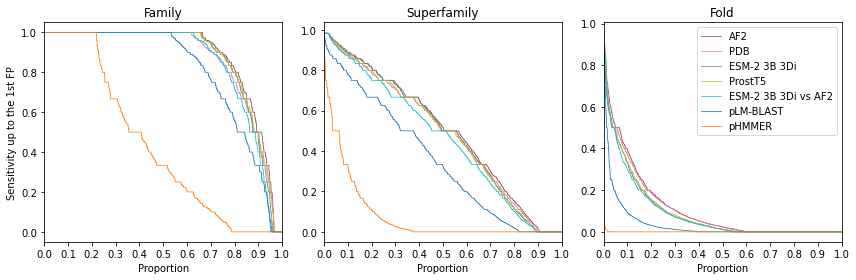

In [14]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
palette = sns.color_palette("tab10")

for i, (dataset, data) in enumerate(hits_data.items()):
    sns.ecdfplot(ax=axes[0], y=data["FAM"], marker=None, label=dataset, complementary=True, linewidth=0.75, color=palette[(i+5) % 10])
    sns.ecdfplot(ax=axes[1], y=data["SFAM"], marker=None, label=dataset, complementary=True, linewidth=0.75, color=palette[(i+5) % 10])
    sns.ecdfplot(ax=axes[2], y=data["FOLD"], marker=None, label=dataset, complementary=True, linewidth=0.75, color=palette[(i+5) % 10])

#set x ticks to 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, and 1.0
for ax in axes:
    ax.set_xticks(np.arange(0, 1.1, 0.1))

axes[0].set_title("Family")
axes[1].set_title("Superfamily")
axes[2].set_title("Fold")
axes[0].set_ylabel("Sensitivity up to the 1st FP")
axes[1].set_ylabel("")
axes[2].set_ylabel("")

# legend visible on axes[2]
axes[2].legend()

# tight layout
plt.tight_layout()
#plt.savefig("sensitivity_cdf.png", dpi=300, facecolor="white")

In [15]:
cross_compare_datasets = dict()
for query in ("AF2", "pdb", "ESM-2", "prostT5"):
    for db in ("AF2", "pdb", "ESM-2", "prostT5" ):
        dataset_name = query + "_" + db
        cross_compare_datasets[dataset_name] = pd.read_table("SCOPe40_processed/" + query + "_" + db + "_processed.tsv")
        print(dataset_name + "\t" + str(mean(cross_compare_datasets[dataset_name]["SFAM"])))


AF2_AF2	0.498997561634885
AF2_pdb	0.4928941064778463
AF2_ESM-2	0.46592669684800897
AF2_prostT5	0.4636137773976444
pdb_AF2	0.4933280367807067
pdb_pdb	0.48643082529725185
pdb_ESM-2	0.46012236281267527
pdb_prostT5	0.4566170812254627
ESM-2_AF2	0.45939373981491866
ESM-2_pdb	0.44684951130398204
ESM-2_ESM-2	0.490988511174986
ESM-2_prostT5	0.4788848710544027
prostT5_AF2	0.4551562083903533
prostT5_pdb	0.4445753778014582
prostT5_ESM-2	0.48045619110768367
prostT5_prostT5	0.48276676402411667
